In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import missingno as msno
import seaborn as sns
from datetime import datetime, date

import schema

Task Specification:
Patterns of behavior in different regions of the sensor view as defined by behavior zones.
1. Pedestrians using the ramp vs stairs
2. Bicycles using the sidewalk vs bikelane.

In each case, we want to see how counts vary over the course of the day.


So, some important things are object detection + DEEPSORT (object tracking) for the actual counting process.

In [2]:
behavior_zones = pd.read_csv("../../data/behavior_zones.csv")
# data = pd.read_csv("../../data/data.csv", converters={"geo_bottom_center": literal_eval, "bottom_center": literal_eval})
data = pd.read_csv("../../data/data.csv")
img_filepath = "../../data/sample_image.jpg"
data.columns

Index(['trackid', 'date', 'time', 'class', 'box', 'bottom_center',
       'geo_bottom_center'],
      dtype='object')

In [3]:
# Verify that the schema works as intended
data = schema.format_data(data)
data.dtypes

trackid                      object
date                 datetime64[ns]
time                         object
class                      category
box                          object
bottom_center                object
geo_bottom_center            object
datetime             datetime64[ns]
dtype: object

In [4]:
# behavior_zones seems to contain regions in the sensor view.
# Visualize to make sense of the regions:

img = Image.open(img_filepath)
Drawer = ImageDraw.Draw(img)
for _, rows in behavior_zones.iterrows():
    box = [rows["xmin"], rows["ymin"], rows["xmax"], rows["ymax"]]
    Drawer.rectangle(box, fill=None)

# img.show()


<AxesSubplot:>

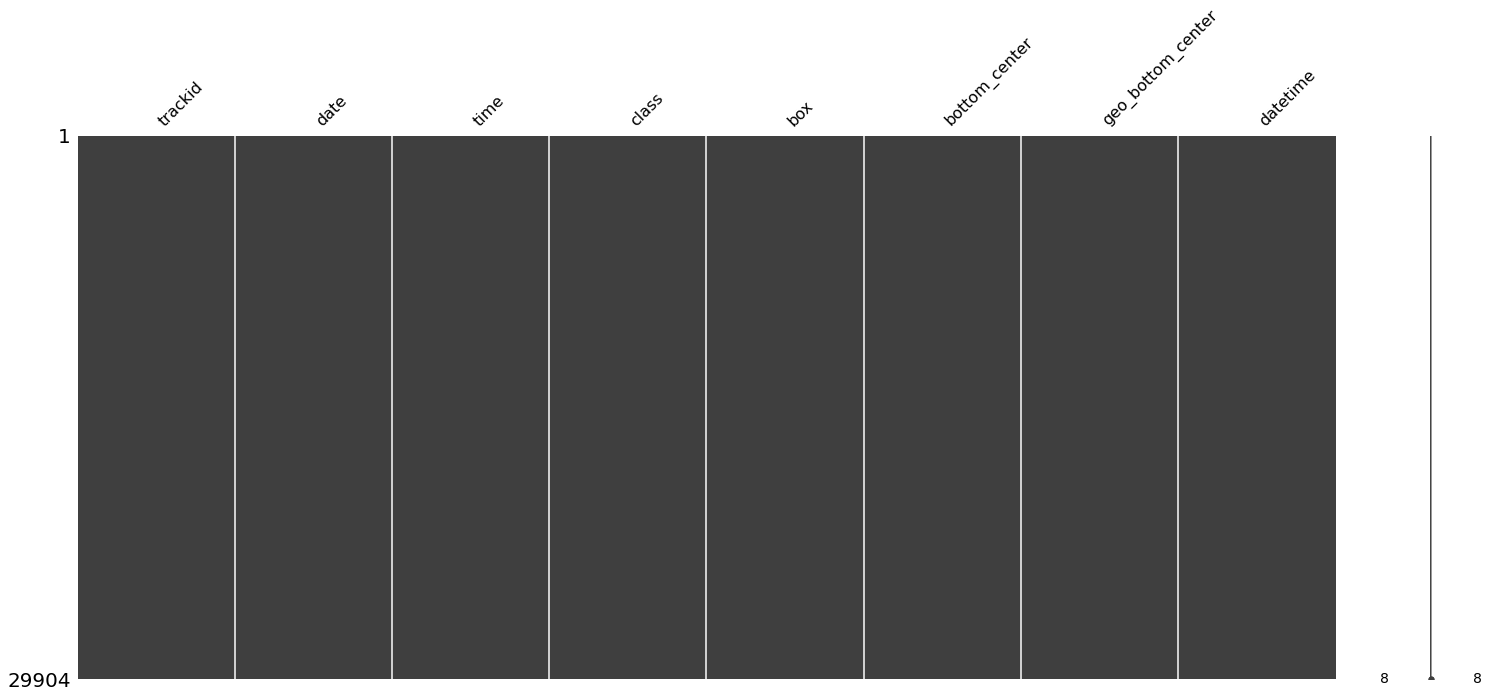

In [5]:
# Inspect missingness in the data, and see if there are immediate correlations that could potentially be identified.
msno.matrix(data)


## Initial Gameplan
The following list was what I THOUGHT the game plan should be. I soon realized Step 0 was a gross over-complication. The data format allowed me to go straight to Step 1.

* Step 0. Create a class object of `pedestrian` and `bicycles` depending on 'class'. -- referring to DEEPSORT code.
* Step 1. Verify if the `bottom_center` position is within any of the pre-set boundaries listed in `behavior_zone`. Will keep track of direction.
* Step 2. If the point is inside the set boundary, update the counter. To ensure that we can take care of instances where a pedestrian reaches multiple locations, we should ensure that the `pedestrian` can qualify for multiple tracks.
* Step 3. Test how many objects we find -- and see how far it is from 1918. Evaluate.

* Step 4. Consider ways that I can make code reproducible. 

We have four, non-overlapping areas. Since there are only 4, we should see if they traverse any of them -- separately.

In [6]:
# ## Fixing Datetime columns
# data['time'] = pd.to_datetime(data.time, format='%H:%M:%S.%f').dt.time
# data['date'] = pd.to_datetime(data.date)
# [datetime.combine(date, time) for date, time in zip(data.date, data.loc[:,'time'])]


In [7]:
## Step 1: Classifying coordinates into regions
# Seperate coordinates for easier vectorization
data.loc[:, 'bottom_x'] = data.bottom_center.map(lambda x: x[0])
data.loc[:, 'bottom_y'] = data.bottom_center.map(lambda x: x[1])

# Dummy variables for each region
data['w_stairs'] = data.bottom_x.between(380, 530) & data.bottom_y.between(80, 200)
data['w_ramp'] = data.bottom_x.between(70, 350) & data.bottom_y.between(100, 200)
data['w_sidewalk'] = data.bottom_x.between(180, 415) & data.bottom_y.between(200, 280)
data['w_bikelane'] = data.bottom_x.between(180, 415) & data.bottom_y.between(290, 380)

# just verifying that there aren't multi-classifications
within_cols = data.columns[data.columns.str.startswith('w_')].tolist()
data['w_any'] = data[within_cols].sum(axis=1)
assert data.w_any.max() == 1

data['w_any'].value_counts()

0    17010
1    12894
Name: w_any, dtype: int64

In [8]:
# remove entries that do not contribute to count
count_data = data[data["w_any"] > 0].reset_index(drop=True).drop(columns=['box', 'w_any', 'bottom_center'])
first_counts = (
    count_data.sort_values(by=["time"]).groupby("trackid", as_index=False).first()
).rename(columns={'time': 'enter_time'})
last_counts = (
    count_data.sort_values(by=["time"]).groupby("trackid", as_index=False).last()
).rename(columns={'time': 'exit_time'})
total_counts = (
    count_data.sort_values(by=['time']).groupby("trackid", as_index=False)['time'].count()
).rename(columns={'time': 'time_counts'})

assert (first_counts.shape == last_counts.shape)
total_counts['time_counts'].describe()

count    1559.000000
mean        8.270686
std        14.019695
min         1.000000
25%         3.000000
50%         5.000000
75%         9.000000
max       176.000000
Name: time_counts, dtype: float64

In [9]:
count_data = first_counts.merge(
    last_counts, on=["trackid", "class"] + within_cols, suffixes=("_enter", "_exit")
).merge(total_counts)
# remove those that just have one instance -- refer to Appendix
count_data = count_data[count_data['time_counts'] > 1]

count_data['where_am_i'] = count_data[within_cols].idxmax(axis=1) # this is safe, because I have verified every row has entry
count_data = count_data.drop(columns=within_cols)

In [10]:
count_data.head()

,trackid,date_enter,enter_time,class,geo_bottom_center_enter,datetime_enter,bottom_x_enter,bottom_y_enter,date_exit,exit_time,geo_bottom_center_exit,datetime_exit,bottom_x_exit,bottom_y_exit,time_counts,where_am_i
0,00021e3c52304eec9940637cff6c0af0,2020-05-03,16:10:06.533000,pedestrian,"[40.69921586515186, -73.96260713950586]",2020-05-03 16:10:06.533,202,271,2020-05-03,16:10:10.873000,"[40.69927299320927, -73.96259981011559]",2020-05-03 16:10:10.873,407,230,10,w_sidewalk
2,017a9e48b59d4c7c93912747b01e7c86,2020-05-03,13:58:17.431000,pedestrian,"[40.69923824962516, -73.96256262163347]",2020-05-03 13:58:17.431,391,307,2020-05-03,13:58:18.318000,"[40.699206478975746, -73.96257504452788]",2020-05-03 13:58:18.318,237,333,3,w_bikelane
3,01a710d65e424f809d5e0b4d19fec825,2020-05-03,13:10:46.908000,pedestrian,"[40.699340747659555, -73.96260608521398]",2020-05-03 13:10:46.908,529,189,2020-05-03,13:10:53.420000,"[40.699334123951544, -73.96260698065248]",2020-05-03 13:10:53.420,517,191,13,w_stairs
4,01c069defc0546b4969dd88d114ced3e,2020-05-03,11:07:05.730000,pedestrian,"[40.699274707710245, -73.96260654260443]",2020-05-03 11:07:05.730,398,222,2020-05-03,11:07:09.445000,"[40.69921937912562, -73.96261762184679]",2020-05-03 11:07:09.445,194,253,9,w_sidewalk
5,01ccca82c73142e4a339d8d7090e80bb,2020-05-03,16:48:25.192000,pedestrian,"[40.69921592968284, -73.96260637826896]",2020-05-03 16:48:25.192,204,272,2020-05-03,16:48:29.392000,"[40.699267369615, -73.96259322784942]",2020-05-03 16:48:29.392,406,241,10,w_sidewalk


# Next Steps towards the Solution 
1. Given the quick turnaround, I will bucket the individuals by their datetime_enter. Resample by `hour`, and provide a graph and count.
2. For additional context, I would have calculated the velocity of travel using 
$$\frac{\text{geo\_bottom\_center\_exit} - \text{geo\_bottom\_center\_enter}}{\text{datetime\_exit} - \text{datetime\_enter}}$$
and would also infer direction of travel. Would have included that in Step 1 to modify count.

3. Would revise the `first` and `last` classification to ensure that each `trackid` does not have multiple `environment_zone` classification. i.e if a pedestrian stepped into the bike lane due to traffic, this should not affect the counts.

# Appendix
There seems to be a problem where objects stop being detected, and therefore have the same 'enter' and 'exit' timestamps.
Given my experience with YOLO and SORT, I know that this is a very common phenomenon. Some potential solutions may be: 
* kalman filter: we can back-fill the data by generating some predictions on how the object * would-have * moved through the space. (difficulty: HARD)
* Expanding the number of tracked objects: Allowing for multi-level object detection. In other words, dont restrict the detection to just `pedestrian`, but also `hat`, `bag`, etc. Classify with same `trackid` via iou of bounding boxes, and at the same `datetime`. So, even if the detector loses track of `pedestrian` bounding box, the measurement may be more robust to failure. (difficulty: MEDIUM)
* `class`: the detection or SORT algorithm may be losing track of the object because it is being classified differently (difficulty: EASY)

In [11]:
# This problem is relevant to both bicycles and pedestrians. So, it may not be a matter of speed.


# There is probably a way to interpolate values. With the data provided prior to entering the bounding boxes.
data[data.trackid.isin(total_counts[total_counts['time_counts'] == 1].trackid)]['class'].value_counts()

pedestrian    708
bicycle       417
truck           0
Name: class, dtype: int64